In [ ]:
# Install Kaggle (if not present) and import libraries
!pip install -q kaggle

# Standard imports
import os, shutil, random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models

print("TensorFlow version:", tf.__version__)

print("GPU available:", tf.test.is_gpu_available())


In [14]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
#for dataset download
!kaggle datasets download -d emmarex/plantdisease

# Unzip into folder 'plant_disease'
!unzip -q plantdisease.zip -d plant_disease
!ls -la plant_disease | sed -n '1,120p'

In [15]:
data_dir = "/kaggle/input/plantdisease/PlantVillage"   #  dataset folder 
base_dir = "/kaggle/working/dataset_binary"


In [16]:
# Prepare binary dataset: Healthy vs Diseased

data_dir = "/kaggle/input/plantdisease/PlantVillage"
base_dir = "/kaggle/working/dataset_binary"

import shutil
from sklearn.model_selection import train_test_split
for split in ["train","val","test"]:
    for cls in ["Healthy","Diseased"]:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Move/copy images into binary folders
for cls in sorted(os.listdir(data_dir)):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    label = "Healthy" if "healthy" in cls.lower() else "Diseased"
    imgs = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if len(imgs) == 0:
        continue
    train, test = train_test_split(imgs, test_size=0.2, random_state=42)
    val, test = train_test_split(test, test_size=0.5, random_state=42)
    for subset, subset_dir in zip([train, val, test], [os.path.join(base_dir,'train',label), os.path.join(base_dir,'val',label), os.path.join(base_dir,'test',label)]):
        for img in subset:
            try:
                shutil.copy(img, subset_dir)
            except Exception as e:
                print("Could not copy", img, "=>", e)

# Quick counts
for split in ["train","val","test"]:
    print("\nCounts in", split)
    for cls in ["Healthy","Diseased"]:
        p = os.path.join(base_dir, split, cls)
        n = len([f for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        print(f"  {cls}: {n}")


Counts in train
  Healthy: 2575
  Diseased: 13929

Counts in val
  Healthy: 322
  Diseased: 1742

Counts in test
  Healthy: 324
  Diseased: 1746


In [17]:
#imageDataGenerator
IMG_SIZE = (224,224)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'), 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir,'val'), 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir,'test'), 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary', 
    shuffle=False
)


Found 16504 images belonging to 2 classes.
Found 2064 images belonging to 2 classes.
Found 2070 images belonging to 2 classes.


In [14]:
import os, shutil
from sklearn.model_selection import train_test_split

# Kaggle dataset path
data_dir = "/kaggle/input/plantdisease/PlantVillage"   #  new dataset folder 
base_dir = "/kaggle/working/dataset_binary"            # dataset save 

# Create binary directories
for split in ["train","val","test"]:
    for cls in ["Healthy","Diseased"]:
        os.makedirs(os.path.join(base_dir, split, cls), exist_ok=True)

# Move/copy images into binary folders
for cls in sorted(os.listdir(data_dir)):
    cls_path = os.path.join(data_dir, cls)
    if not os.path.isdir(cls_path):
        continue
    label = "Healthy" if "healthy" in cls.lower() else "Diseased"
    imgs = [os.path.join(cls_path, f) for f in os.listdir(cls_path) if f.lower().endswith(('.png','.jpg','.jpeg'))]
    if len(imgs) == 0:
        continue
    train, test = train_test_split(imgs, test_size=0.2, random_state=42)
    val, test = train_test_split(test, test_size=0.5, random_state=42)
    for subset, subset_dir in zip(
        [train, val, test],
        [os.path.join(base_dir,'train',label),
         os.path.join(base_dir,'val',label),
         os.path.join(base_dir,'test',label)]
    ):
        for img in subset:
            try:
                shutil.copy(img, subset_dir)
            except Exception as e:
                print("Could not copy", img, "=>", e)

# Quick counts
for split in ["train","val","test"]:
    print("\nCounts in", split)
    for cls in ["Healthy","Diseased"]:
        p = os.path.join(base_dir, split, cls)
        n = len([f for f in os.listdir(p) if f.lower().endswith(('.png','.jpg','.jpeg'))])
        print(f"  {cls}: {n}")



Counts in train
  Healthy: 2575
  Diseased: 13929

Counts in val
  Healthy: 322
  Diseased: 1742

Counts in test
  Healthy: 324
  Diseased: 1746


In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


# Dataset base directory (already created in the previous step)
base_dir = "/kaggle/working/dataset_binary"

# ImageDataGenerators (augmentation for train)   image size
IMG_SIZE = (224,224)
BATCH_SIZE = 32

# Train data generator with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
# Validation/Test generator (only rescale)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen = train_datagen.flow_from_directory(
    os.path.join(base_dir,'train'), 
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir,'val'),
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_gen = val_test_datagen.flow_from_directory(
    os.path.join(base_dir,'test'),
    target_size=IMG_SIZE, 
    batch_size=BATCH_SIZE, 
    class_mode='binary', 
    shuffle=False
)

Found 16504 images belonging to 2 classes.
Found 2064 images belonging to 2 classes.
Found 2070 images belonging to 2 classes.


In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# ---------------- CNN MODEL ----------------
cnn_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # binary classification
])

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train CNN
history_cnn = cnn_model.fit(train_gen, validation_data=val_gen, epochs=10)


# ---------------- Evaluate CNN ----------------
y_true = test_gen.classes
y_prob_cnn = cnn_model.predict(test_gen)
y_pred_cnn = (y_prob_cnn > 0.5).astype('int32')

print("✅ CNN Classification Report:\n", classification_report(y_true, y_pred_cnn))





/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 163s 312ms/step - accuracy: 0.8432 - loss: 0.5655 - val_accuracy: 0.8658 - val_loss: 0.2850
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 162s 315ms/step - accuracy: 0.9007 - loss: 0.2478 - val_accuracy: 0.9007 - val_loss: 0.2214
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 161s 311ms/step - accuracy: 0.9228 - loss: 0.2027 - val_accuracy: 0.8542 - val_loss: 0.3294
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 159s 308ms/step - accuracy: 0.9362 - loss: 0.1634 - val_accuracy: 0.8832 - val_loss: 0.2651
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 161s 311ms/step - accuracy: 0.9572 - loss: 0.1188 - val_accuracy: 0.9104 - val_loss: 0.2145
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 161s 311ms/step - accuracy: 0.9515 - loss: 0.1381 - val_accuracy: 0.9297 - val_loss: 0.1739
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 159s 308ms/step - accuracy: 0.9612 - loss: 0.1159 - val_accuracy: 0.9075 - val_loss: 0.2880
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 160s 311ms/step - accuracy: 0.9598 -

Epoch 1/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 180s 331ms/step - accuracy: 0.8569 - loss: 0.3393 - val_accuracy: 0.9564 - val_loss: 0.1217
Epoch 2/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 159s 308ms/step - accuracy: 0.9439 - loss: 0.1465 - val_accuracy: 0.9675 - val_loss: 0.0927
Epoch 3/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 158s 307ms/step - accuracy: 0.9529 - loss: 0.1227 - val_accuracy: 0.9719 - val_loss: 0.0832
Epoch 4/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 158s 307ms/step - accuracy: 0.9545 - loss: 0.1138 - val_accuracy: 0.9729 - val_loss: 0.0785
Epoch 5/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 162s 313ms/step - accuracy: 0.9556 - loss: 0.1116 - val_accuracy: 0.9714 - val_loss: 0.0745
Epoch 6/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 159s 308ms/step - accuracy: 0.9596 - loss: 0.1034 - val_accuracy: 0.9758 - val_loss: 0.0741
Epoch 7/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 158s 307ms/step - accuracy: 0.9596 - loss: 0.1016 - val_accuracy: 0.9777 - val_loss: 0.0657
Epoch 8/10
516/516 ━━━━━━━━━━━━━━━━━━━━ 160s 310ms/step - accuracy: 0.9614 -

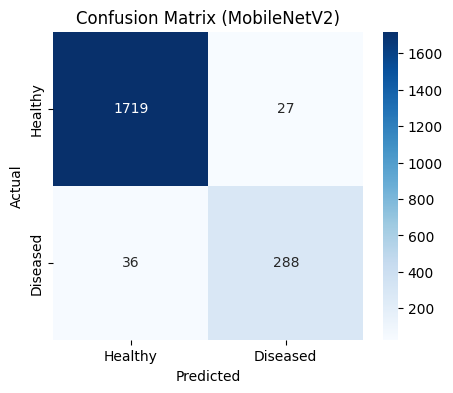

In [21]:
# ---------------- MobileNetV2 MODEL ----------------
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base layers

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output)
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train MobileNetV2
history_mobilenet = mobilenet_model.fit(train_gen, validation_data=val_gen, epochs=10)


# ---------------- Evaluate MobileNetV2 ----------------
y_prob_mnet = mobilenet_model.predict(test_gen)
y_pred_mnet = (y_prob_mnet > 0.5).astype('int32')

print("✅ MobileNetV2 Classification Report:\n", classification_report(y_true, y_pred_mnet))


# ---------------- Confusion Matrix (MobileNetV2) ----------------
cm = confusion_matrix(y_true, y_pred_mnet)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Healthy","Diseased"], yticklabels=["Healthy","Diseased"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (MobileNetV2)")
plt.show()

In [23]:
# ---------------- Summary Table ----------------
results = {
    "Model": ["CNN","MobileNetV2"],
    "Accuracy": [accuracy_score(y_true, y_pred_cnn), accuracy_score(y_true, y_pred_mnet)],
    "Precision": [precision_score(y_true, y_pred_cnn), precision_score(y_true, y_pred_mnet)],
    "Recall": [recall_score(y_true, y_pred_cnn), recall_score(y_true, y_pred_mnet)],
    "F1": [f1_score(y_true, y_pred_cnn), f1_score(y_true, y_pred_mnet)]
}
df_results = pd.DataFrame(results)
print("\n✅ Summary Table:\n", df_results)


✅ Summary Table:
          Model  Accuracy  Precision    Recall        F1
0          CNN  0.899517   0.611111  0.984568  0.754137
1  MobileNetV2  0.969565   0.914286  0.888889  0.901408


Using last conv layer: Conv_1


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_377']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


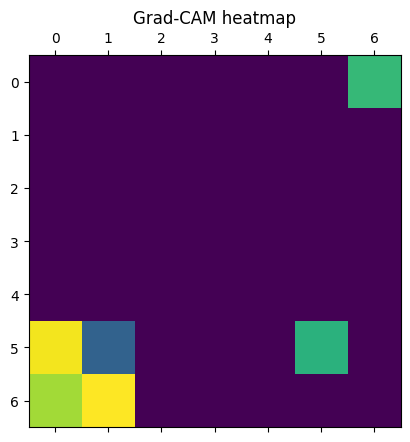

In [24]:
# Grad-CAM example for MobileNetV2 (choose a conv layer name if needed)
import tensorflow as tf
import cv2, numpy as np
def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]
    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-8)
    return heatmap

# Use a test image
if len(test_gen.filepaths) > 0:
    img_path = test_gen.filepaths[0]
    img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
    img_array = tf.keras.utils.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    # Last conv layer name in MobileNetV2 often 'Conv_1' but may vary
    layer_name = None
    for layer in mobilenet_model.layers[::-1]:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer_name = layer.name
            break
    print("Using last conv layer:", layer_name)
    heatmap = get_gradcam_heatmap(mobilenet_model, img_array, layer_name)
    plt.matshow(heatmap)
    plt.title("Grad-CAM heatmap")
    plt.show()
else:
    print("No test images found.")

In [26]:
# Save trained models to Drive (optional)
os.makedirs('/content/drive/MyDrive/plant_models', exist_ok=True)
cnn_model.save('/content/drive/MyDrive/plant_models/cnn_model.keras')
mobilenet_model.save('/content/drive/MyDrive/plant_models/mobilenet_model.keras')
print("Models saved to /content/drive/MyDrive/plant_models/")

Models saved to /content/drive/MyDrive/plant_models/


In [27]:
# ✅ Save trained models in Kaggle
import os

save_dir = "/kaggle/working/plant_models"
os.makedirs(save_dir, exist_ok=True)

cnn_model.save(os.path.join(save_dir, "cnn_model.keras"))
mobilenet_model.save(os.path.join(save_dir, "mobilenet_model.keras"))

print(f"✅ Models saved in {save_dir}")


✅ Models saved in /kaggle/working/plant_models


In [1]:
import os

# Dataset folder path
data_dir = "/kaggle/input/plantdisease"

# Check files inside
print(os.listdir(data_dir))


['PlantVillage', 'plantvillage']


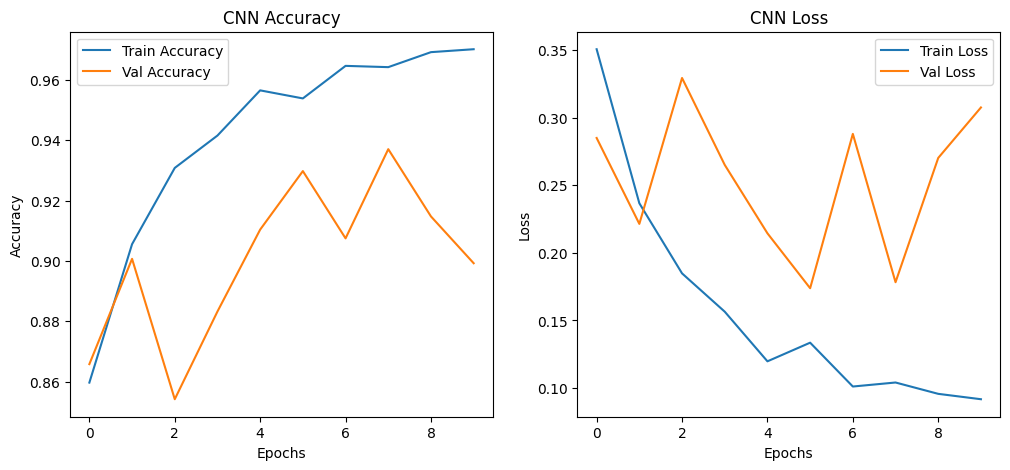

In [28]:
# ---------------- Training Curves (CNN) ----------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Val Accuracy')
plt.title("CNN Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Val Loss')
plt.title("CNN Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()




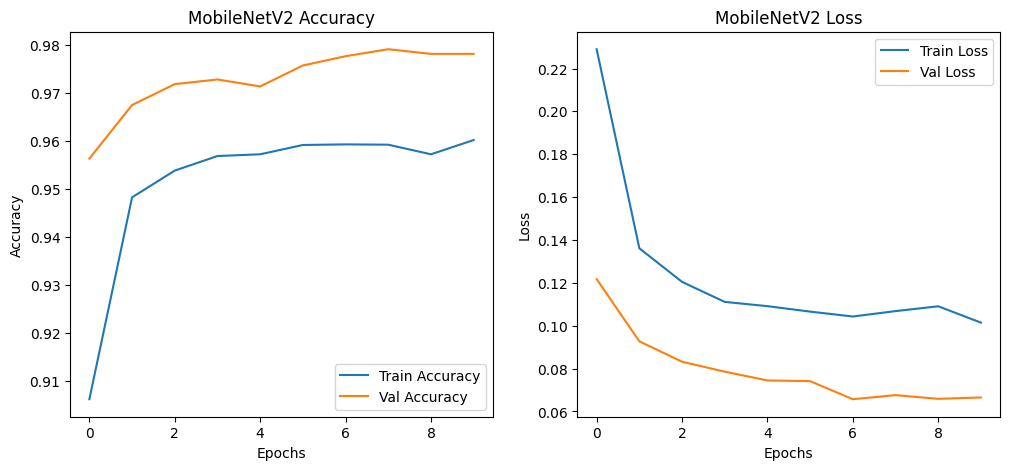

In [29]:
# ---------------- Training Curves (MobileNetV2) ----------------
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_mobilenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenet.history['val_accuracy'], label='Val Accuracy')
plt.title("MobileNetV2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_mobilenet.history['loss'], label='Train Loss')
plt.plot(history_mobilenet.history['val_loss'], label='Val Loss')
plt.title("MobileNetV2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()